# **Requerimientos y librerías**



In [ ]:
!pip install astroquery
!pip install alerce
!pip install P4J

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.8 MB/s eta 0:00:00


In [ ]:
!pip install P4J

In [ ]:
from alerce.core import Alerce
alerce=Alerce()
import numpy as np; import matplotlib.pyplot as plt
import sys ; import pandas as pd
import seaborn as sns; import os
import requests; import astropy.units as u

from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance, Galactic, SkyCoord
from astropy.cosmology import WMAP7
from astroquery.ipac.irsa.irsa_dust import IrsaDust
from astroquery.ned import Ned
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from astroquery.simbad import Simbad
import P4J

# **Definir grupo de RR Lyrae**

---



In [ ]:
lyraes = [ "ZTF18aajusiz", "ZTF18aalarzm", "ZTF18aapmpdr", "ZTF18aapsyhm","ZTF18abjlrkf"]


## **Funciones análisis individual**

In [ ]:
def plotLC(oid, VS_det):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                linestyle='None')


    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

def plot_diffLC(oid, LC_det, LC_nondet):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf,
                yerr = LC_det[mask].sigmapsf, c = colors[fid], fmt=markers[fid], label = labels[fid])

        # plot non detections if available and if wanted:
        mask = (LC_nondet.fid == fid) & (LC_nondet.diffmaglim > -900)
        if (np.sum(mask) > 0):
            # non detections index is mjd
            ax.scatter(LC_nondet[mask].mjd, LC_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                marker = 'v', label = "lim.mag. %s" % labels[fid])

    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("difference magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.show()

def plot_corrLC(oid, LC_det):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf_corr,
                yerr = LC_det[mask].sigmapsf_corr_ext, c = colors[fid], fmt=markers[fid], label = labels[fid])


    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

def get_DR(oid, url="https://api.alerce.online/ztf/dr/v1/light_curve/"):
    stats = alerce.query_object(oid, format='pandas')

    ra = float(stats.meanra)
    dec = float(stats.meandec)
    query = {'ra':ra, 'dec':dec, 'radius':1.5}

    response = requests.get(url, query)
    output = response.json()

    df = []
    for i in output:
        aux = pd.DataFrame({'hmjd': np.array(i["hmjd"]), 'mag': np.array(i["mag"]), "magerr": np.array(i["magerr"])})
        aux["ID"] = int(i["_id"])
        aux["filterid"] = int(i["filterid"])
        aux["oid"] = oid
        df.append(aux)

    if df != []:
        return pd.concat(df) #output
    else:
        return None

In [ ]:
DR = get_DR(lyraes[0])

<ipython-input-94-706504d779bf>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ra = float(stats.meanra)
<ipython-input-94-706504d779bf>:85: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dec = float(stats.meandec)


In [ ]:
def plot_corrLC_DR(oid, LC_det, DR):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    labels1 = {1: 'g DR', 2: 'r DR'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    colors1 = {1: '#ADA3A3', 2: '#377EB8',}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        maskDR = DR.filterid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(DR[maskDR].hmjd, DR[maskDR].mag,
                yerr = DR[maskDR].magerr, c = colors1[fid], fmt=markers[fid], label = labels1[fid], alpha=.3)
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf_corr,
                yerr = LC_det[mask].sigmapsf_corr_ext, c = colors[fid], fmt=markers[fid], label = labels[fid])



    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

def getLCdata(oid, doLC = False,  plot_diff = False, doDR = False):

    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))

    results = {"oid": oid}

    # query detections
    LC_det = alerce.query_detections(oid, format='pandas')
    results["lc_det"] = LC_det

    # query non detections
    LC_nondet = alerce.query_non_detections(oid, format='pandas')
    results["lc_nondet"] = LC_nondet

    # plot the LC
    if doLC:
        if plot_diff:
            plot_diffLC(oid, LC_det, LC_nondet)
        else:
            plot_corrLC(oid, LC_det)

    # plot the LC
    if doDR:
        if plot_diff:
            plot_diffLC(oid, LC_det, LC_nondet)
        else:
            plot_corrLC_DR(oid, LC_det, DR)

    # return data
    return results

In [ ]:
results = getLCdata(lyraes[0], doLC=True, plot_diff = False)

TypeError: getLCdata() got an unexpected keyword argument 'doLC'

In [ ]:
def plotLCcorr(oid, VS_det, A=None):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}

    # loop the passbands
    for fid in [1, 2]:

        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:

            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    alpha=0.1, linestyle='None')
                # show dust attenuation corrected light curve
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr - A_fid,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid],
                    label="%s (ext. corr.)" % labels[fid], linestyle='None')
            else:
                # plot attenuated light curve
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    linestyle='None')

    # labels
    if A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)

    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

def getVSdatacorr(oid, doLC=False, doext=False, dostamp=False, dosimbad=False, showlink=False):

    results = {"oid": oid}
    #grmean
    VS_grmean=alerce.query_objects(oid,format="pandas")
    # query basic stats
    VS_stats = alerce.query_object(oid, format='pandas')
    results["stats"] = VS_stats

    # query magnitude stats
    VS_magstats = alerce.query_magstats(oid, format='pandas',)
    results["magstats"] = VS_magstats

    # query detections
    VS_det = alerce.query_detections(oid, format='pandas')
    VS_det = VS_det.sort_values("mjd")
    results["lc_det"] = VS_det

    # object coordinates
    co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
                              frame='icrs')

    # get SIMBAD query
    if dosimbad:
        Simbad_table = Simbad.query_region(co, radius=0.01 * u.deg, equinox=2000)
        display(Simbad_table)
        results["simbad_table"] = Simbad_table

    # get Galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
             "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLCcorr(oid, VS_det, A)
        else:
            plotLCcorr(oid, VS_det)

    if showlink:
        display(HTML("<a href='http://dev.alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))

    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = alerce.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace=0, hspace=0)

    return results

In [ ]:
results = getVSdatacorr(lyraes[0], doLC=True, doext=True, dostamp=True, showlink=True)

TypeError: AlerceSearch.query_objects() got multiple values for argument 'format'

In [ ]:
def doperiod_multiband(VS_det, showperiod=False):

    mjds, mags, errs, fids = VS_det[["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T

    # Compute periodogram
    my_per = P4J.MultiBandPeriodogram(method='MHAOV')
    my_per.set_data(mjds, mags, errs, fids)
    my_per.frequency_grid_evaluation(fmin=1e-3, fmax=20.0, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)

    best_freq, best_per = my_per.get_best_frequencies()
    freq_mb, per_mb = my_per.get_periodogram()
    period_mb = 1.0 / best_freq[0]

    if showperiod:
        print('Multiband period: %.6f days' % period_mb)

    period = {}
    freq = {}
    per = {}
    labels = {1: 'g', 2: 'r'}

    for fid in [1, 2]:
        freq[fid], per[fid] = my_per.get_periodogram(fid)
        best_freq = my_per.get_best_frequency(fid)
        period[fid] = 1. / best_freq

        if showperiod:
            print("Period %s: %.6f days" % (labels[fid], period[fid]))

    return period_mb, freq_mb, per_mb, period, freq, per

def plotperiod_multiband(oid, VS_det, dofold=False, showperiodograms=False,
                         period_mb=None, freq_mb=None, per_mb=None,
                         period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}
    colors = {1: '#56E03A', 2: '#D42F4B'}

    for idx, fid in enumerate([1, 2]):
        maskdet = VS_det.fid == fid

        if dofold:
            phase = np.mod(VS_det[maskdet].mjd, period_mb) / period_mb
            for nphase in [0, 1]:
                if nphase == 0:
                    label = labels[fid]
                else:
                    label = None
                ax.errorbar(phase + nphase, VS_det[maskdet].magpsf_corr,
                        yerr = VS_det[maskdet].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=label,
                        markersize=5, linestyle='None')
        else:
            ax.errorbar(VS_det[maskdet].mjd, VS_det[maskdet].magpsf_corr,
                    yerr=VS_det[maskdet].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    linestyle='None')

    if dofold:
        ax.set_title("%s (multiband period: %.6f days)" % (oid, period_mb))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

    if dofold and showperiodograms:
        fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

        for idx, fid in enumerate([0, 1, 2]):
            if idx==0:
                ax[idx].plot(freq_mb, per_mb)
                ax[idx].set_title("Multiband periodogram")
                ax[idx].set_xlabel("frequency [1/days]")
            else:
                ax[idx].plot(freq[fid], per[fid])
                ax[idx].set_title("Periodogram %s (period: %.6f days)" % (labels[fid], period[fid]))
                ax[idx].set_xlabel("frequency [1/days]")
def getLCdata(oid, results, doplot=False, dofold=False, showperiod=False, showperiodograms=False):
    if dofold:
        # get period
        period_mb, freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"],
                                                                           showperiod=showperiod)
        results["period_multiband"] = period_mb
        results["period_band"] = period
    else:
        period = None; freq = None; per = None
        period_mb = None; freq_mb = None; per_mb = None

    if doplot:
        plotperiod_multiband(oid, results["lc_det"], dofold, showperiodograms,
                             period_mb=period_mb, freq_mb=freq_mb, per_mb=per_mb,
                             period=period, freq=freq, per=per)

    return results

In [ ]:
results = getVSdatacorr(lyraes[0])
periodogram = getLCdata(lyraes[0], results, doplot=True, dofold=True, showperiod=True, showperiodograms=True)

TypeError: AlerceSearch.query_objects() got multiple values for argument 'format'

In [ ]:
period_mb_test = 0.678794
results = getVSdatacorr(lyraes[0])
plotperiod_multiband(lyraes[0], results["lc_det"], dofold=True, period_mb=period_mb_test)

In [ ]:
mjds, mags, errs, fids = results["lc_det"][["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T

# Compute periodogram
my_per = P4J.MultiBandPeriodogram(method='MHAOV')
my_per.set_data(mjds, mags, errs, fids)
my_per.frequency_grid_evaluation(fmin=1e-3, fmax=10.0, fresolution=1e-4)
my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=5)

best_freq, best_per = my_per.get_best_frequencies()
freq_mb, per_mb = my_per.get_periodogram()
period_mb = 1.0 / best_freq[0]

print('Multiband period: %.6f days' % period_mb)

plotperiod_multiband(lyraes[0], results["lc_det"], dofold=True, period_mb=period_mb)

## **Funciones para grupos**

In [ ]:
for oid in lyraes:
    results = getVSdatacorr(oid, doLC=True)

In [ ]:
for oid in lyraes:
    results = getVSdatacorr(oid, doLC=True, doext=True, dostamp=True)

In [ ]:
for oid in lyraes:
    results = getVSdatacorr(oid)
    periodogram = getLCdata(oid, results, doplot=True, dofold=True, showperiodograms=True)

# **Estimación distancias**

In [ ]:
feh = [-2.92, -1.14, -1.23, -1.66,-0.153]
afe = 0.3
f = 10**afe
mh = feh + np.log10(0.638 * f + 0.362)
logZ = mh - 1.765
#print("f =", f)
#print("[M/H] =", mh)
#print("log(Z) =", logZ)

noid = len(lyraes)
mg = np.zeros(noid)
mr = np.zeros(noid)
period_mb = np.zeros(noid)
period_g = np.zeros(noid)
period_r = np.zeros(noid)

for i, oid in enumerate(lyraes):
    results = getVSdatacorr(oid, doext=True)
    mg[i] = results["magstats"].magmean[0] - results["attenuation"]["g"]
    mr[i] = results["magstats"].magmean[1] - results["attenuation"]["r"]
    period_mb[i], freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"])
    period_g[i] = period[1]
    period_r[i] = period[2]

Mg = 1.646 + 0.307 * logZ
Mr = 1.097 - 0.587 * np.log10(period_mb) + 0.238 * logZ

# Estimate distance using the m-d distance
dist_g = 10**(0.2 * (mg - Mg + 5.0))
dist_r = 10**(0.2 * (mr - Mr + 5.0))


<ipython-input-21-5b5e62eaf7ee>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
<ipython-input-21-5b5e62eaf7ee>:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
<ipython-input-21-5b5e62eaf7ee>:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
<ipython-input-21-5b5e62eaf7ee>:67: FutureWarning: Calling float on a

In [ ]:
g_r_max_corr_ext_att = np.zeros(noid)
g_r_mean_corr_ext_att = np.zeros(noid)

for i, oid in enumerate(lyraes):
    results = getVSdatacorr(oid, doext=True, doLC=False, dostamp=False)
    g_r_max_corr_ext_att[i] = results["stats"].g_r_max_corr - results["attenuation"]["g"] + results["attenuation"]["r"]
    g_r_mean_corr_ext_att[i] = results["stats"].g_r_mean_corr - results["attenuation"]["g"] + results["attenuation"]["r"]

<ipython-input-21-5b5e62eaf7ee>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
<ipython-input-21-5b5e62eaf7ee>:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
<ipython-input-21-5b5e62eaf7ee>:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
<ipython-input-70-8ff7b74b5679>:6: FutureWarning: Calling float on a 

In [ ]:
rrl_sample = pd.DataFrame(lyraes, columns=['oid'])
rrl_sample['Mg'] = Mg # Absolute Magnitude g, M_g
rrl_sample['Mr'] = Mr # Absolute Magnitude r, M_r
rrl_sample['mg'] = mg # Apparent Magnitude g, m_g
rrl_sample['mr'] = mr # Apparent Magnitude r, m_r
rrl_sample['dist_g'] = dist_g # Distance g filter (pc)
rrl_sample['dist_r'] = dist_r # Distance r filter (pc)
rrl_sample['period_mb'] = period_mb # Multiband period (days)
rrl_sample['period_g'] = period_g # g-band period (days)
rrl_sample['period_r'] = period_r # r-band period (days)
rrl_sample['g_r_max'] = g_r_max_corr_ext_att # g-r color @ max
rrl_sample['g_r_mean'] = g_r_mean_corr_ext_att # mean(g-r) color
rrl_sample = rrl_sample.set_index('oid')

In [ ]:
def plot_properties(propx, propy, propx_label, propy_label, dodiag=False):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(propx, propy, alpha=0.5)
    ax.set_xlabel("%s" % propx_label)
    ax.set_ylabel("%s" % propy_label)

    if dodiag:
        t = np.arange(min(propx)-0.1, max(propx)+0.1, 0.01)
        s = t
        ax.plot(t, s,color='gray', linestyle='--',label="y=x")
        ax.legend()

In [ ]:
display(rrl_sample)

,Mg,Mr,mg,mr,dist_g,dist_r,period_mb,period_g,period_r,g_r_max,g_r_mean
oid,,,,,,,,,,,
ZTF18aajusiz,0.273253,0.131555,17.691675,17.525960,30456.807544,30121.798929,0.678794,0.678794,0.678794,NaN,NaN
ZTF18aalarzm,0.819713,0.646912,15.583549,15.742175,8969.478207,10448.465939,0.473687,0.473687,0.473687,NaN,NaN
ZTF18aapmpdr,0.792083,0.499685,16.020587,16.132415,11109.660282,13382.771126,0.775915,0.775915,0.068979,NaN,NaN
ZTF18aapsyhm,0.660073,0.475358,14.373470,14.016178,5529.417453,5106.977442,0.571363,0.571363,0.571363,NaN,NaN
ZTF18abjlrkf,1.122722,1.025904,15.789857,16.155136,8578.808611,10613.199204,0.269172,0.269172,0.269172,NaN,NaN


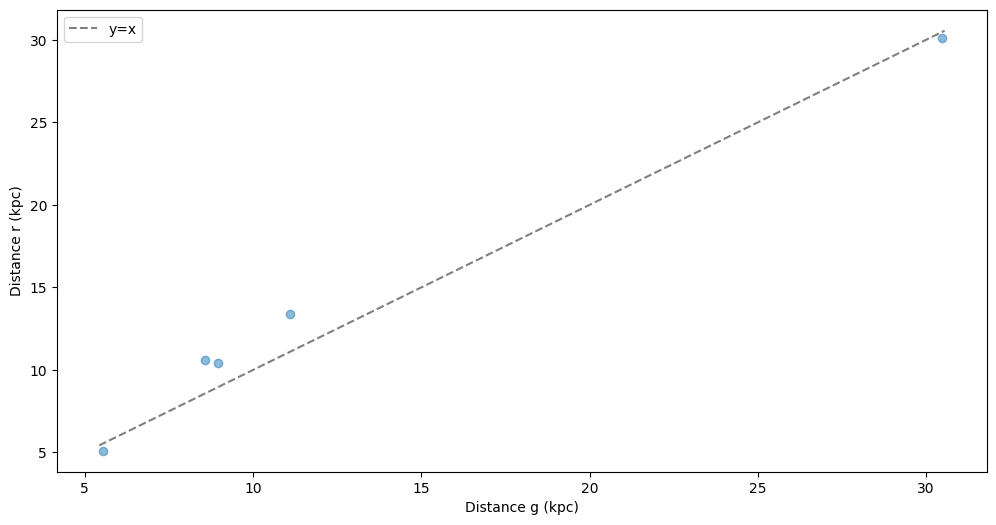

In [ ]:
plot_properties(propx=rrl_sample['dist_g']/1000., propy=rrl_sample['dist_r']/1000.,
                propx_label="Distance g (kpc)", propy_label="Distance r (kpc)", dodiag=True)